In [189]:
import pandas as pd
from collections import Counter
import numpy as np
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import MinMaxScaler

import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv,ResGatedGraphConv,GATv2Conv,SAGEConv,GCNConv
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.loader import NeighborSampler, NeighborLoader
import copy
import tqdm

import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.utils.convert import to_networkx, from_networkx
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

In [2]:
df = pd.read_csv('D:\\xyj\\projects\\E-ResGAT-master\\mydata\\UNSW-NB15_1.csv', header=None)

D:\anaconda\envs\lightgbm_catboost\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (1,3,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [79]:
df

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,175.45.176.3,6875,149.171.126.16,520,udp,INT,0.000004,104,0,254,...,0,0,14,8,3,5,3,1,3,6
1,175.45.176.1,8454,149.171.126.13,135,tcp,FIN,0.539181,1612,354,254,...,0,0,5,5,2,2,2,1,2,6
2,175.45.176.3,15278,149.171.126.15,179,tcp,FIN,0.459588,916,556,254,...,0,0,10,10,2,2,2,1,2,6
3,175.45.176.0,64810,149.171.126.19,80,tcp,FIN,0.367687,2550,268,254,...,0,0,10,10,1,1,1,1,1,6
4,175.45.176.1,0,149.171.126.12,0,unas,INT,0.000001,200,0,254,...,0,0,16,16,4,4,4,4,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62210,175.45.176.0,4618,149.171.126.17,80,tcp,FIN,0.560773,1306,268,254,...,0,0,1,1,1,2,1,1,1,7
62211,175.45.176.3,7566,149.171.126.14,80,tcp,FIN,2.095087,2004,263720,254,...,0,0,4,1,1,3,2,1,1,7
62212,175.45.176.2,10815,149.171.126.18,80,tcp,FIN,0.315213,1302,268,254,...,0,0,1,3,1,1,1,1,1,7
62213,175.45.176.1,29092,149.171.126.15,80,tcp,FIN,3.993750,2416,308476,254,...,0,0,1,2,1,1,1,1,1,7


In [4]:
df[47] = df[47].fillna('Normal')

In [5]:
label = df[47]

In [6]:
Counter(label)

Counter({'Normal': 677786,
         'Exploits': 5409,
         'Reconnaissance': 1759,
         'DoS': 1167,
         'Generic': 7522,
         'Shellcode': 223,
         ' Fuzzers': 5051,
         'Worms': 24,
         'Backdoors': 534,
         'Analysis': 526})

In [7]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,Normal,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,Normal,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,Normal,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,Normal,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,Normal,0


In [8]:
x = df.drop(columns=[47, 48])
y = df[47]

In [9]:
Counter(y)

Counter({'Normal': 677786,
         'Exploits': 5409,
         'Reconnaissance': 1759,
         'DoS': 1167,
         'Generic': 7522,
         'Shellcode': 223,
         ' Fuzzers': 5051,
         'Worms': 24,
         'Backdoors': 534,
         'Analysis': 526})

In [10]:
rus = RandomUnderSampler(random_state=0, sampling_strategy={
    'Normal': 40000,
     'Exploits': 5409,
     'Reconnaissance': 1759,
     'DoS': 1167,
     'Generic': 7522,
     'Shellcode': 223,
     ' Fuzzers': 5051,
     'Worms': 24,
     'Backdoors': 534,
     'Analysis': 526
})
LABELS_12 = {
    'Normal': 0,
     'Exploits': 1,
     'Reconnaissance': 2,
     'DoS': 3,
     'Generic': 4,
     'Shellcode':5,
     ' Fuzzers': 6,
     'Worms': 7,
     'Backdoors': 8,
     'Analysis': 9
}

In [11]:
x, y = rus.fit_resample(x, y)

In [12]:
label = [LABELS_12[v] for v in y]

In [13]:
Counter(y)

Counter({' Fuzzers': 5051,
         'Analysis': 526,
         'Backdoors': 534,
         'DoS': 1167,
         'Exploits': 5409,
         'Generic': 7522,
         'Normal': 40000,
         'Reconnaissance': 1759,
         'Shellcode': 223,
         'Worms': 24})

In [14]:
df = x

In [15]:
df[47] = label

In [16]:
df

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,175.45.176.3,6875,149.171.126.16,520,udp,INT,0.000004,104,0,254,...,0,0,14,8,3,5,3,1,3,6
1,175.45.176.1,8454,149.171.126.13,135,tcp,FIN,0.539181,1612,354,254,...,0,0,5,5,2,2,2,1,2,6
2,175.45.176.3,15278,149.171.126.15,179,tcp,FIN,0.459588,916,556,254,...,0,0,10,10,2,2,2,1,2,6
3,175.45.176.0,64810,149.171.126.19,80,tcp,FIN,0.367687,2550,268,254,...,0,0,10,10,1,1,1,1,1,6
4,175.45.176.1,0,149.171.126.12,0,unas,INT,0.000001,200,0,254,...,0,0,16,16,4,4,4,4,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62210,175.45.176.0,4618,149.171.126.17,80,tcp,FIN,0.560773,1306,268,254,...,0,0,1,1,1,2,1,1,1,7
62211,175.45.176.3,7566,149.171.126.14,80,tcp,FIN,2.095087,2004,263720,254,...,0,0,4,1,1,3,2,1,1,7
62212,175.45.176.2,10815,149.171.126.18,80,tcp,FIN,0.315213,1302,268,254,...,0,0,1,3,1,1,1,1,1,7
62213,175.45.176.1,29092,149.171.126.15,80,tcp,FIN,3.993750,2416,308476,254,...,0,0,1,2,1,1,1,1,1,7


In [17]:
features = df.iloc[:, 4:]

In [18]:
features

,4,5,6,7,8,9,10,11,12,13,...,38,39,40,41,42,43,44,45,46,47
0,udp,INT,0.000004,104,0,254,0,0,0,-,...,0,0,14,8,3,5,3,1,3,6
1,tcp,FIN,0.539181,1612,354,254,252,2,1,-,...,0,0,5,5,2,2,2,1,2,6
2,tcp,FIN,0.459588,916,556,254,252,5,3,-,...,0,0,10,10,2,2,2,1,2,6
3,tcp,FIN,0.367687,2550,268,254,252,2,1,http,...,0,0,10,10,1,1,1,1,1,6
4,unas,INT,0.000001,200,0,254,0,0,0,-,...,0,0,16,16,4,4,4,4,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62210,tcp,FIN,0.560773,1306,268,254,252,2,1,http,...,0,0,1,1,1,2,1,1,1,7
62211,tcp,FIN,2.095087,2004,263720,254,252,2,100,http,...,0,0,4,1,1,3,2,1,1,7
62212,tcp,FIN,0.315213,1302,268,254,252,2,1,http,...,0,0,1,3,1,1,1,1,1,7
62213,tcp,FIN,3.993750,2416,308476,254,252,2,116,http,...,0,0,1,2,1,1,1,1,1,7


In [19]:
le1 = preprocessing.LabelEncoder()
features[4] = le1.fit_transform(features[4])
le2 = preprocessing.LabelEncoder()
features[5] = le2.fit_transform(features[5])
le3 = preprocessing.LabelEncoder()
features[13] = le3.fit_transform(features[13])

In [20]:
features = features.iloc[:, :-1]

In [21]:
features

,4,5,6,7,8,9,10,11,12,13,...,37,38,39,40,41,42,43,44,45,46
0,117,5,0.000004,104,0,254,0,0,0,0,...,0,0,0,14,8,3,5,3,1,3
1,111,4,0.539181,1612,354,254,252,2,1,0,...,0,0,0,5,5,2,2,2,1,2
2,111,4,0.459588,916,556,254,252,5,3,0,...,0,0,0,10,10,2,2,2,1,2
3,111,4,0.367687,2550,268,254,252,2,1,5,...,1,0,0,10,10,1,1,1,1,1
4,118,5,0.000001,200,0,254,0,0,0,0,...,0,0,0,16,16,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62210,111,4,0.560773,1306,268,254,252,2,1,5,...,1,0,0,1,1,1,2,1,1,1
62211,111,4,2.095087,2004,263720,254,252,2,100,5,...,1,0,0,4,1,1,3,2,1,1
62212,111,4,0.315213,1302,268,254,252,2,1,5,...,1,0,0,1,3,1,1,1,1,1
62213,111,4,3.993750,2416,308476,254,252,2,116,5,...,0,0,0,1,2,1,1,1,1,1


In [22]:
mms = MinMaxScaler()

In [23]:
features = mms.fit_transform(features)

In [24]:
features

array([[9.00000000e-01, 6.25000000e-01, 4.56580489e-10, ...,
        5.88235294e-02, 0.00000000e+00, 5.40540541e-02],
       [8.53846154e-01, 5.00000000e-01, 6.15448811e-05, ...,
        2.94117647e-02, 0.00000000e+00, 2.70270270e-02],
       [8.53846154e-01, 5.00000000e-01, 5.24597284e-05, ...,
        2.94117647e-02, 0.00000000e+00, 2.70270270e-02],
       ...,
       [8.53846154e-01, 5.00000000e-01, 3.59800264e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.53846154e-01, 5.00000000e-01, 4.55867082e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.53846154e-01, 5.00000000e-01, 6.79508195e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [25]:
Counter(label)

Counter({6: 5051,
         9: 526,
         8: 534,
         3: 1167,
         1: 5409,
         4: 7522,
         0: 40000,
         2: 1759,
         5: 223,
         7: 24})

# 操作********************************************

In [26]:
src_ip = df[0]
src_port = df[1]
dst_ip = df[2]
dst_port = df[3]

In [27]:
src_ip = np.array(src_ip)
dst_ip = np.array(dst_ip)
src_port = np.array(src_port)
dst_port = np.array(dst_port)

In [28]:
src_nodes = list(zip(src_ip, src_port))
dst_nodes = list(zip(dst_ip, dst_port))

In [29]:
socket_dict = list(zip(src_nodes, dst_nodes))

In [91]:
len(socket_dict)

62215

In [30]:
all_nodes = set(src_nodes).union(set(dst_nodes))

In [31]:
len(all_nodes)

65024

In [32]:
nodes_to_no_dict = dict()
for index,value in enumerate(all_nodes):
    nodes_to_no_dict[value] = index

In [33]:
num_edge = len(src_nodes)
num_edge

62215

In [34]:
socket_adj_map = {}
socket_no_map = {}
for index, value in enumerate(socket_dict):
    # 获取发出者编号
    s, d = value[0], value[1]
    s_no = nodes_to_no_dict[s]
    d_no = nodes_to_no_dict[d]
    if s_no not in socket_adj_map:
        socket_adj_map[s_no] = []
    if s_no not in socket_no_map:
        socket_no_map[s_no] = []
    socket_adj_map[s_no].append(d_no)
    socket_no_map[s_no].append(index)

In [123]:
adj_list = {}

In [124]:
def build_edge_index(arr):
    for i in range(len(arr)):
        if arr[i] not in adj_list:
            adj_list[arr[i]] = set()
        for j in range(len(arr)):
            if i != j:
                adj_list[arr[i]].add(arr[j])
        

In [125]:
for index, value in socket_no_map.items():
    build_edge_index(value)

In [126]:
for key, value in socket_adj_map.items():
    for i in range(len(value)):
        adj_no = value[i]
        no = socket_no_map[key][i]
        if adj_no in socket_adj_map and len(socket_adj_map[adj_no]) != 0:
            adj_values = socket_adj_map[adj_no]
            for j in range(len(adj_values)):
                if adj_values[j] == key:
                    a = no
                    b = socket_no_map[adj_no][j]
                    adj_list[a].add(b)
                    adj_list[b].add(a)

In [127]:
len(adj_list)

62215

In [128]:
adj_list[55]

{8192,
 8193,
 4,
 8196,
 8201,
 8203,
 8205,
 21,
 22,
 29,
 8222,
 8223,
 8225,
 39,
 8233,
 8235,
 8237,
 47,
 8240,
 56,
 60,
 8253,
 62,
 63,
 64,
 65,
 8254,
 8256,
 68,
 8257,
 8263,
 8267,
 78,
 80,
 81,
 8272,
 8276,
 8280,
 8282,
 8288,
 8291,
 101,
 8300,
 8302,
 8303,
 112,
 8310,
 8311,
 120,
 8313,
 8317,
 127,
 129,
 8326,
 139,
 144,
 8337,
 150,
 153,
 8348,
 161,
 162,
 8353,
 165,
 8359,
 8360,
 8364,
 8366,
 176,
 8373,
 182,
 183,
 185,
 8378,
 8384,
 199,
 8391,
 8393,
 8402,
 211,
 8405,
 215,
 216,
 218,
 8413,
 229,
 230,
 8422,
 8425,
 8426,
 235,
 238,
 239,
 240,
 241,
 8431,
 243,
 8439,
 8441,
 8447,
 264,
 265,
 8456,
 8457,
 269,
 271,
 8465,
 276,
 8468,
 278,
 8474,
 8478,
 290,
 8482,
 8483,
 294,
 295,
 297,
 301,
 8507,
 321,
 8513,
 8514,
 324,
 328,
 8520,
 333,
 338,
 341,
 346,
 8542,
 355,
 368,
 8561,
 8563,
 372,
 8565,
 8567,
 378,
 379,
 8571,
 386,
 8578,
 388,
 389,
 391,
 403,
 8595,
 406,
 409,
 410,
 8603,
 413,
 8605,
 8608,
 422,
 42

In [116]:
arr = []
for k, v in adj_list.items():
    lv = len(v)
    arr.append(lv)
sorted(arr, reverse=True)

[2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,
 2969,

In [129]:
adj_dict = {}

In [130]:
for k, v in adj_list.items():
    if k not in adj_dict:
        adj_dict[k] = []
    for value in v:
        adj_dict[k].append(value)

In [131]:
count = set()
for k, v in adj_dict.items():
    count.add(k)
    for value in v:
        count.add(value)

In [132]:
max(count)

62214

In [133]:
len(adj_dict)

62215

In [135]:
arr = np.array(arr)
print(len(arr))
len(arr[arr==0])

62215


45717

In [136]:
import networkx as nx
G = nx.from_dict_of_lists(adj_dict)

In [137]:
G.number_of_nodes()

62215

In [138]:
data = from_networkx(G)

In [139]:
data

Data(edge_index=[2, 22801262], num_nodes=62215)

In [140]:
features = torch.tensor(features, dtype=torch.float)
label = torch.tensor(label, dtype=torch.long)

D:\anaconda\envs\lightgbm_catboost\lib\site-packages\ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
D:\anaconda\envs\lightgbm_catboost\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [141]:
data.x = features
data.y = label

In [142]:
alltrainidx = np.arange(num_edge)

In [143]:
alltrainidx

array([    0,     1,     2, ..., 62212, 62213, 62214])

In [144]:
train_mask, test_mask = train_test_split(alltrainidx, test_size=0.15, stratify=label.numpy(), random_state=1)

In [145]:
train_mask = torch.tensor(train_mask, dtype=torch.long)
test_mask = torch.tensor(test_mask, dtype=torch.long)

In [146]:
data.train_mask = train_mask
data.test_mask = test_mask

In [147]:
data.has_isolated_nodes()

True

In [148]:
num_class = 10
features_num = 43
hidden = 16

In [160]:
device = torch.device('cuda:0')
data = data.to(device)

In [150]:
torch.cuda.set_device(0)

# 开始训练

In [ ]:
hop1 = 25
hop2 = 10

In [173]:
train_loader = NeighborLoader(data, input_nodes = data.train_mask, num_neighbors=[hop1, hop2], batch_size=1024, shuffle=True, directed=False)

In [174]:
subgraph_loader = NeighborLoader(copy.copy(data), input_nodes=None,num_neighbors=[hop1, hop2], batch_size=1024, shuffle=False, directed=False)
del subgraph_loader.data.x, subgraph_loader.data.y
# Add global node index information.
subgraph_loader.data.num_nodes = data.num_nodes
subgraph_loader.data.n_id = torch.arange(data.num_nodes)

In [175]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GATv2Conv(in_channels, hidden_channels))
        self.convs.append(GATv2Conv(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = x.relu_()
                x = F.dropout(x, p=0.1, training=self.training)
        return x

    @torch.no_grad()
    def inference(self, x_all, subgraph_loader):
        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch:
        for i, conv in enumerate(self.convs):
            xs = []
            for batch in subgraph_loader:
                x = x_all[batch.n_id.to(x_all.device)].to(device)
                x = conv(x, batch.edge_index.to(device))
                if i < len(self.convs) - 1:
                    x = x.relu_()
                xs.append(x[:batch.batch_size].cpu())
            x_all = torch.cat(xs, dim=0)
        return x_all


In [176]:
model = Net(features_num, hidden, num_class).to(device)  # 定义GAT
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [177]:
def train():
    total_loss = total_correct = total_examples = 0
    for batch in train_loader:
        optimizer.zero_grad()
        y = batch.y[:batch.batch_size]
        y_hat = model(batch.x, batch.edge_index.to(device))[:batch.batch_size]
        loss = F.cross_entropy(y_hat, y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * batch.batch_size
        total_correct += int((y_hat.argmax(dim=-1) == y).sum())
        total_examples += batch.batch_size
    print(total_loss / total_examples)

    return total_loss / total_examples, total_correct / total_examples

In [178]:
from sklearn.metrics import f1_score, classification_report

In [183]:
model.train()
loss_all = []
epochs = 100
for i in range(epochs):
    loss, acc = train()
    loss_all.append(loss)

0.16589771114214524
0.1659318663281034
0.1663771967412502
0.1647959540896677
0.16579514077795304
0.16622319338852878
0.16802391474627315
0.16646285853055093
0.16581658486708414
0.16500279487029204
0.16450366959314494
0.16501982545087118
0.16681997482291347
0.1654968161015732
0.16514722995809725
0.16455718355326532
0.16510030948988613
0.16423278622029702
0.16617710083449178
0.16515557453059415
0.16516162397147693
0.1648190205427942
0.1652910795966876
0.16375627882798652
0.16404140499512712
0.16478504305547984
0.16322323511531478
0.16372965119232735
0.16290487876415324
0.16402245542101923
0.1635330174501362
0.1631995351940505
0.1644951524786029
0.16394806410619267
0.164746578434656
0.16431136444413325
0.1618369228996725
0.16328005336129509
0.16363578574769072
0.16409791928075057
0.16400343411721519
0.1618181017885536
0.1622302189972599
0.16358844434943134
0.1631841045335825
0.16397539725528082
0.16371112253953252
0.16238007165438326
0.1637730804955985
0.16258424040506206
0.16173452645938

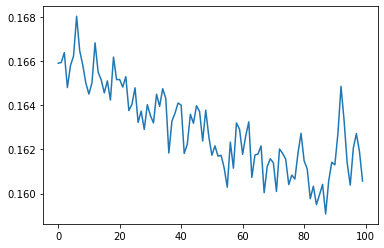

In [184]:
plt.plot(loss_all)

In [185]:
model.eval()
y_hat = model.inference(data.x, subgraph_loader).argmax(dim=-1)
y = data.y.to(y_hat.device)
cr1 = classification_report(y[test_mask], y_hat[test_mask],digits=4)
cr2 = classification_report(y[train_mask], y_hat[train_mask],digits=4)
print(cr1)
print(cr2)

              precision    recall  f1-score   support

           0     0.9993    0.9938    0.9966      6001
           1     0.6768    0.9063    0.7749       811
           2     0.7398    0.8939    0.8096       264
           3     0.4000    0.0800    0.1333       175
           4     1.0000    0.9902    0.9951      1128
           5     0.5714    0.2424    0.3404        33
           6     0.9099    0.9327    0.9212       758
           7     0.0000    0.0000    0.0000         4
           8     0.0000    0.0000    0.0000        80
           9     1.0000    0.2152    0.3542        79

    accuracy                         0.9427      9333
   macro avg     0.6297    0.5255    0.5325      9333
weighted avg     0.9350    0.9427    0.9328      9333

              precision    recall  f1-score   support

           0     0.9996    0.9945    0.9971     33999
           1     0.6905    0.9278    0.7918      4598
           2     0.7445    0.8849    0.8087      1495
           3     0.5071 

D:\anaconda\envs\lightgbm_catboost\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\envs\lightgbm_catboost\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\envs\lightgbm_catboost\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\envs\lightgbm

In [190]:
confusion_matrix(y[test_mask], y_hat[test_mask])

array([[5964,    5,    2,    0,    0,    0,   30,    0,    0,    0],
       [   0,  735,   37,   14,    0,    5,   20,    0,    0,    0],
       [   0,   18,  236,    1,    0,    0,    9,    0,    0,    0],
       [   0,  144,   10,   14,    0,    1,    6,    0,    0,    0],
       [   0,    7,    3,    0, 1117,    0,    1,    0,    0,    0],
       [   1,    2,   19,    0,    0,    8,    3,    0,    0,    0],
       [   2,   39,   10,    0,    0,    0,  707,    0,    0,    0],
       [   0,    4,    0,    0,    0,    0,    0,    0,    0,    0],
       [   1,   73,    2,    4,    0,    0,    0,    0,    0,    0],
       [   0,   59,    0,    2,    0,    0,    1,    0,    0,   17]],
      dtype=int64)

In [ ]:
model

In [ ]:
torch.save(model.state_dict(),'unswnb15_best_model')

# 机器学习和最基础的DNN 训练

In [187]:
from sklearn.ensemble import *
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:
x_new = features.numpy()
y_new = label.numpy()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_new, y_new, test_size=0.15)

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

In [ ]:
Counter(y_train)

In [ ]:
Counter(y_test)

In [ ]:
rfc = LGBMClassifier()

In [ ]:
rfc.fit(x_train, y_train)

In [ ]:
y_pred = rfc.predict(x_test)

In [ ]:
cr = classification_report(y_test,y_pred)

In [ ]:
cr

In [ ]:
import torch.nn as nn

myNet = nn.Sequential(
    nn.Linear(43, 16),
    nn.ReLU(),
    nn.Linear(16, 10),
    nn.Softmax()
)


In [ ]:
optimzer2 = torch.optim.Adam(myNet.parameters(), lr=0.05)
loss_func = nn.CrossEntropyLoss()

In [ ]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float)
x_test_tensor = torch.tensor(x_test, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [ ]:
for epoch in range(100):
    out = myNet(x_train_tensor)
    loss = loss_func(out, y_train_tensor)  # 计算误差
    optimzer2.zero_grad()  # 清除梯度
    loss.backward()
    optimzer2.step()

In [ ]:
pred = myNet(x_test_tensor)

In [ ]:
pred  = pred.detach().numpy()

In [ ]:
y_test.shape

In [ ]:
pred.shape

In [ ]:

prob_all = []
prob_all.extend(pred[:,1])

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, prob_all, pos_label=2)

In [ ]:
np.mean(fpr)

In [ ]:
auc(fpr, tpr)

In [ ]:
pred = np.argmax(pred, -1)

In [ ]:
pred

In [ ]:
classification_report(y_test,y_pred)